In [ ]:
!pip install torchtext==0.5.0
!pip install transformers

In [ ]:
!pip install https://github.com/sobhe/hazm/archive/master.zip --upgrade

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm 
import torch
import torchtext
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
from collections import Counter

In [4]:
from hazm import *
normalizer = Normalizer()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd drive/MyDrive/DeepLearning/data

/content/drive/MyDrive/DeepLearning/data


In [7]:
data = open('ferdousi.txt').read()
poem = data.lower().split("\n")[2:]

In [8]:
def Create_Vocab(corpus):
  counter = Counter()
  for text in tqdm(corpus):
    words = word_tokenize(normalizer.normalize(text))
    counter.update(words)
  return Vocab(counter)
Ferdousi_Vocab = Create_Vocab(poem)

100%|██████████| 99217/99217 [00:11<00:00, 8361.61it/s]


In [9]:
def process(corpus, vocab):
    data = list()
    for text in tqdm(corpus):
        token_list = [vocab[token] for token in word_tokenize(normalizer.normalize(text))]
        for i in range(1, len(token_list)):
            n_gram_seq = torch.tensor(token_list[:i+1], dtype=torch.long)
            data.append(n_gram_seq)
    return data

train_data = process(poem, Ferdousi_Vocab)

X = [i[:-1] for i in train_data]
X = pad_sequence(X, batch_first=True, padding_value=Ferdousi_Vocab.stoi['<pad>'])
y = [i[-1] for i in train_data]
y = torch.from_numpy(np.array(y))
train_data = TensorDataset(X, y)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

100%|██████████| 99217/99217 [00:13<00:00, 7112.98it/s]


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
class LSTM(nn.Module):
    def __init__(self, vocab_size,dropout=0.10):
        super().__init__()
        self.hidden_size = 128
        self.num_layers = 2
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, 128)
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=2, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(128, vocab_size)
        
    def forward(self, X, h=None, c=None):
        if h is None:
            h, c = self.init_state(X.size(0))
        output = self.embedding(X)
        output, (h, c) = self.lstm(output, (h, c))
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc1(output)
        output = output.view(-1, X.size(1), self.vocab_size)
        output = output[:, -1]
        return output, h, c
    def init_state(self, batch_size):
        num_l = self.num_layers
        hidden = torch.zeros(num_l, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(num_l, batch_size, self.hidden_size).to(device)
        return hidden, cell

In [11]:
def ACC(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True).reshape(y.size())
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc,top_pred

In [38]:
LSTM_model = LSTM(len(Ferdousi_Vocab)).to(device)
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

EPOCH:30 - Loss: 4.76% - Accuracy: 16.52%: 100%|██████████| 7263/7263 [01:02<00:00, 115.72it/s]


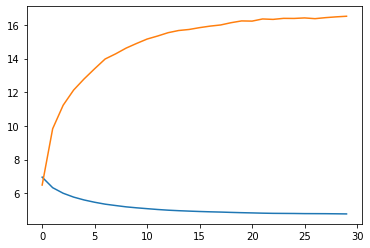

In [39]:
epochs = 30
lose = []
acc_array = []
LSTM_model.train()
for epoch in range(epochs):
    epoch_loss = 0
    accuracy = 0
    with tqdm(enumerate(train_dataloader),total=len(train_dataloader)) as teacher:
      for i,(X, y) in teacher:
          X = X.to(device)
          y = y.to(device)
          optimizer.zero_grad()
          output, h, c = LSTM_model(X)
          loss = criterion(output, y)
          acc , _ = ACC(output, y)
          accuracy += acc
          epoch_loss += loss
          loss.backward()
          optimizer.step()
          if(i%5 == 0):
            teacher.set_description(f'EPOCH:{epoch+1} - Loss: {epoch_loss/(i+1):.2f}% - Accuracy: {accuracy*100/(i+1):.2f}%')
      lose.append((epoch_loss/len(teacher)).cpu().item())
      acc_array.append((accuracy*100/len(teacher)).cpu().item())
      if (lose[-1]<=min(lose)):
          torch.save(LSTM_model.state_dict(), 'FerdousiAI.pth')
plt.plot(np.array(lose))
plt.plot(np.array(acc_array))
plt.show()

In [15]:
class GRU(nn.Module):
    def __init__(self, vocab_size, dropout=0.1):
        super().__init__()
        self.hidden_size = 128
        self.num_layers = 2
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, 128)
        self.gru = nn.GRU(input_size=128, hidden_size=128, num_layers=2, dropout=0.1, batch_first=True)
        self.fc1 = nn.Linear(128, vocab_size)
        
    def forward(self, X, h=None, c=None):
        if h is None:
            h, c = self.init_state(X.size(0))
        output = self.embedding(X)
        output, h = self.gru(output, h)
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc1(output)
        output = output.view(-1, X.size(1), self.vocab_size)
        output = output[:, -1]
        return output, h, c
    
    def init_state(self, batch_size):
        num_l = self.num_layers
        hidden = torch.zeros(num_l, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(num_l, batch_size, self.hidden_size).to(device)
        return hidden, cell

In [16]:
GRU_model = GRU(len(Ferdousi_Vocab)).to(device)
optimizer = torch.optim.Adam(GRU_model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [17]:
epochs = 30
lose2 = []
acc_array2 = []
GRU_model.train()
for epoch in range(epochs):
    epoch_loss = 0
    accuracy = 0
    with tqdm(enumerate(train_dataloader),total=len(train_dataloader)) as teacher:
      for i,(X, y) in teacher:
          X = X.to(device)
          y = y.to(device)
          optimizer.zero_grad()
          output, h, c = GRU_model(X)
          loss = criterion(output, y)
          acc , _ = ACC(output, y)
          accuracy += acc
          epoch_loss += loss
          loss.backward()
          optimizer.step()
          teacher.set_description(f'EPOCH:{epoch+1} - Loss: {epoch_loss/(i+1):.2f}% - Accuracy: {accuracy*100/(i+1):.2f}%')
      lose2.append((epoch_loss/len(teacher)).cpu().item())
      acc_array2.append((accuracy*100/len(teacher)).cpu().item())
      if (lose2[-1]<=min(lose2)):
          torch.save(GRU_model.state_dict(), 'FerdousiAI2.pth')

EPOCH:30 - Loss: 5.19% - Accuracy: 13.79%: 100%|██████████| 7263/7263 [01:14<00:00, 97.63it/s] 


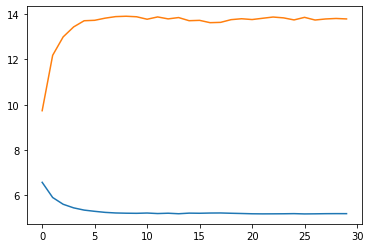

In [18]:
plt.plot(np.array(lose2))
plt.plot(np.array(acc_array2))
plt.show()

In [36]:
text = str(input("Enter your poem:"))
lenght_sent = len(text.split(' '))
next_words = lenght_sent*11
print('GRU: \n')
seed_text = text
i = 0
while i != next_words:
    token_list = np.ones(21, dtype=int)
    text_token = np.array([Ferdousi_Vocab[token] for token in word_tokenize(normalizer.normalize(seed_text))])
    if len(text_token)>21:
      text_token = text_token[-21:]
    token_list[:len(text_token)] = text_token
    token_list = torch.from_numpy(token_list).unsqueeze(0).to(device)
    out,h,c = GRU_model(token_list)
    idx = torch.argmax(out)

    if last_idx != idx and Ferdousi_Vocab.itos[idx]!='؟':
      seed_text += " " + Ferdousi_Vocab.itos[idx]
      last_idx = idx
      i+=1

for i,word in enumerate(seed_text.split()):
    print(word,end=" "),
    if i!=0 and (i+1)%lenght_sent==0:
        print("")


Enter your poem:زنی بود بر سان گردی سوار
GRU: 

زنی بود بر سان گردی سوار 
سپهر دراز اوی خاست اوی دست 
اوی نیز اوی ایچ اوی راه 
اوی خوید اوست آستی گیر راست 
اوی راست اوی راست اوی راست 
اوی گیر راست اوی راست کوز 
رابهی گیر رابهی ازوی رابهی وار 
رابهی اند خوان گیر ازوی رابهی 
ازوی رابهی گیر رابهی گیر رابهی 
طوش رابهی پود گیر ازوی خوان 
رابهی جای هوش کور هوش نی 
خوید اوی دود رابهی گیر اوی 


In [41]:
text = str(input("Enter your poem:"))
lenght_sent = len(text.split(' '))
next_words = lenght_sent*11
print('LTSM: \n')
seed_text = text
i = 0
while i != next_words:
    token_list = np.ones(21, dtype=int)
    text_token = np.array([Ferdousi_Vocab[token] for token in word_tokenize(normalizer.normalize(seed_text))])
    if len(text_token)>21:
      text_token = text_token[-21:]
    token_list[:len(text_token)] = text_token
    token_list = torch.from_numpy(token_list).unsqueeze(0).to(device)
    out,h,c = LSTM_model(token_list)
    idx = torch.argmax(out)

    if last_idx != idx and Ferdousi_Vocab.itos[idx]!='؟':
      seed_text += " " + Ferdousi_Vocab.itos[idx]
      last_idx = idx
      i+=1

for i,word in enumerate(seed_text.split()):
    print(word,end=" "),
    if i!=0 and (i+1)%lenght_sent==0:
        print("")


Enter your poem:زنی بود بر سان گردی سوار
LTSM: 

زنی بود بر سان گردی سوار 
و ز کردار او را به 
هامون ببیم و ملخ و درد 
و به خشم بشکوفهٔ پرگهرش ماغ 
کمندی ستایندهٔ پوشیدنش ستایندهٔ بساسانیان بمیرم 
ستایندهٔ چودانی ازکه نشستنگهش بخط دیرینه 
بدرم ستایندهٔ کمندی ستایندهٔ کمندی ستایندهٔ 
بدرم ستایندهٔ بدرم ستایندهٔ کمندی ستایندهٔ 
بدرم ستایندهٔ برافگندی ستایندهٔ کمندی شیز 
ستایندهٔ بخط دیرینه گنهکار‌گر کمندی ستایندهٔ 
بدرم ستایندهٔ برافگندی ستایندهٔ کمندی ستایندهٔ 
بدرم ستایندهٔ بدرم ستایندهٔ کمندی ستایندهٔ 
